# Add Memory

The chatbot can now use tools to answer user questions, but it does not remeber the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through *persistent checkpointing*. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling a graph, LangGraph automatically saves the state after each step.

When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to puck up where it left off.

Creating a StateGraph with tools to continue with this example

In [4]:
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from IPython.display import display, Image
from typing import TypedDict, Annotated, Sequence
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [5]:
# Create a State for the Graph

class AgentState(TypedDict):
    messages: Annotated[Sequence, add_messages]

In [7]:
# defining the llm and the tools

tool = TavilySearch(max_results=2)
tools = [tool]

llm = init_chat_model("ollama:llama3.2")

llm_with_tools = llm.bind_tools(tools=tools)

In [8]:
# defining the methods for graph nodes

def chatbot(state: AgentState) -> AgentState:
    response = llm_with_tools.invoke(state.get('messages'))

    return {"messages": [response]}


tool_node = ToolNode(tools=tools)


In [9]:
# creating a StateGraph and adding the nodes & edges

graph_builder = StateGraph(AgentState)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph = graph_builder.compile()

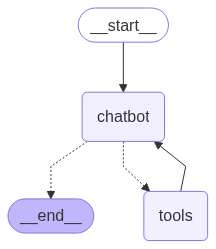

In [10]:
# displaying the graph
display(Image(graph.get_graph().draw_mermaid_png()))

## 1. Create a `MemorySaver` checkpointer

This is in-memory checkpointer, which is convenient for the tutorial. However, in a production application, you would likely change this to use `SqliteSaver` or `PostgresSaver` and connect a Data Base

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## 2. Compile the graph
Compile the graph with the provided checkpointer, which will checkpoint the `AgentState` as the graph works through each node:

In [13]:
graph = graph_builder.compile(checkpointer=memory)

## 3. Interact with your chatbot
1. Pick a thread to use as the key for this conversation

In [14]:
config = {"configurable": {"thread_id": "1"}}

2. Call your chatbot

In [15]:
user_input = "Hi there!, My name is Eswar Maganti."
initial_state = {"messages": [{"role":"user", "content":user_input}]}
events = graph.stream(
    input=initial_state,
    config=config,
    stream_mode="values"
)

for event in events:
    event.get("messages")[-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is Eswar Maganti.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (dbecb91c-0b67-42b1-9e90-b4cb3916627b)
 Call ID: dbecb91c-0b67-42b1-9e90-b4cb3916627b
  Args:
    exclude_domains: None
    include_domains: None
    include_images: False
    query: Hello
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Hello", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Hello_(Adele_song)", "title": "Hello (Adele song) - Wikipedia", "content": "\"**Hello**\" is a song recorded by British singer-songwriter [Adele](https://en.wikipedia.org/wiki/Adele \"Adele\"), released on 23 October 2015 by [XL Recordings](https://en.wikipedia.org/wiki/XL_Recordings 

## 4. Ask a follow up question

In [16]:
user_input = "Remember my name?"
initial_state = {"messages": [{"role":"user", "content":user_input}]}
events = graph.stream(
    input=initial_state,
    config=config,
    stream_mode="values"
)

for event in events:
    event.get("messages")[-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (06261be8-1964-4bd5-a5d1-fa0c9b61002d)
 Call ID: 06261be8-1964-4bd5-a5d1-fa0c9b61002d
  Args:
    include_domains: None
    include_images: False
    query: Hello Eswar Maganti
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Hello Eswar Maganti", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://github.com/eswarmaganti", "title": "Eswar Krishna Maganti eswarmaganti - GitHub", "content": "Prevent this user from interacting with your repositories and sending you notifications.\nLearn more about [blocking users](https://docs.github.com/articles/blocking-a-user-from-your-personal-account).\n\nYou must be logged in to 

**Notice** that we aren't using an external list for memory: It;s all handled by the checkpointer!

Don't believe me? This this with a different config.

In [17]:
events = graph.stream(
    {"messages": [{"role":"user", "content": user_input}]},
    {"configurable": {"thread_id":"2"}},
    stream_mode="values"
)

for event in events:
    event.get("messages")[-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6086ede8-a1cf-4d0d-9b92-6557573abd31)
 Call ID: 6086ede8-a1cf-4d0d-9b92-6557573abd31
  Args:
    include_domains: None
    include_images: False
    query: climate change news
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "climate change news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.climatechangenews.com/", "title": "Climate Home News", "content": "Climate Home News is an award-winning independent digital publication reporting on the international politics of the climate crisis.\n\n![Image 62](https://www.climatechangenews.com/wp-content/files/2025/02/Drum-Awards.svg)![Image 63](https://www.climat

## 5. Inspect the state
By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [19]:
snapshot = graph.get_state(config=config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there!, My name is Eswar Maganti.', additional_kwargs={}, response_metadata={}, id='25edb97d-c594-4a41-b954-b4dd5b3087fc'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-06-13T12:32:29.821084Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9000930750, 'load_duration': 2328658125, 'prompt_eval_count': 958, 'prompt_eval_duration': 5125103583, 'eval_count': 50, 'eval_duration': 1532773750, 'model_name': 'llama3.2'}, id='run--a36c33d3-d899-4919-8ec8-79fb31388300-0', tool_calls=[{'name': 'tavily_search', 'args': {'exclude_domains': None, 'include_domains': None, 'include_images': False, 'query': 'Hello', 'search_depth': 'advanced', 'time_range': None, 'topic': 'general'}, 'id': 'dbecb91c-0b67-42b1-9e90-b4cb3916627b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 958, 'output_tokens': 50, 'total_tokens': 1008}), ToolMessage(content='{"query": "Hello", "foll

In [20]:
snapshot.next

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `END` state, so `next` is empty.